# Templatematching beide Seiten

https://www.open3d.org/html/tutorial/pipelines/icp_registration.html

- point to plain ist etwas langsamer, müssen erst normals berechnet werden
- threshold 0.02 funktioniert zumindest bei Punkten oben (0.2 nicht)
- zentrum des Clusterpaars ist nicht geeignet: bei Lücke ist es sehr stark verschoben
- translation init_transform
    - Wenn Punkte oben auf der Schiene, dann z am besten im Zentrum; mit translation nach oben funktioniert es nicht mehr gut
    - Wenn Punkte auf Seite, dann umgekehrt: translation nach oben führt zu OK match, ansonsten matcht es meist an der falschen Stelle
    - trotzdem nur halbwegs gut
        - z.B. matcht die Innenseite des Stegs gegen die eigentliche Außenseite und am Kopf entsprechend verrutscht
    - transform mit max z funktioniert bei "PunkteOben" nicht richtig, template landet viel zu hoch!?

In [2]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.linalg import svd 
from osgeo import ogr
import pyvista as pv
import os
import json
import time 
import matplotlib.pyplot as plt
import copy

import open3d as o3d
from interessant import * # Bei Änderungen Kernel neu starten


ogr.UseExceptions()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [52]:
gauge = 1.435
railhead_width = 0.067

In [3]:
def pca(cloud):
    """Use PCA to get einvalues and eigenvectors of a point cloud
    
    Returns (eigenvalues, eigenvectors)
    """
    if cloud.shape[0] < 3:
        raise ValueError("Point cloud must have at least 3 points")
    mean = np.mean(cloud, axis=0)
    centered = cloud - mean
    U, S, Vt = svd(centered, full_matrices=False)
    eigenvals = S**2/(cloud.shape[0]-1)
    # Returned vectors are in columns, first vector is eigenvec[:, 0] == eigenvec.T[0]
    return eigenvals, Vt.T

In [120]:
def get_central_point(a, b):
    """Get the point in the middle of two points"""
    vector = b - a
    return a + vector / 2

In [4]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax
    

In [ ]:
def plot_cluster_pair(cluster, cluster_other, transformmatrix, percentile=95, railhead_width = 0.067, centering="cluster"): 
    """Plot pair of clusters in the PCA coordinate system of the pair 
    
    Args:
        cluster (np.array): Cluster of points
        cluster_other (np.array): Other cluster of points
        eigenvects (np.array): Eigenvectors of the PCA of the pair of clusters
        percentile (int): Percentile of the height for the horizontal line
        railhead_width (float): Width of the railhead (0.067 or 0.072)
        centering (str): "cluster" or "pair"
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)

    if centering == "cluster":
        cluster = cluster - center_cluster
        cluster_other = cluster_other - center_other
    else:
        cluster = cluster - center
        cluster_other = cluster_other - center

    transformed = cluster @ transformmatrix
    transformed_other = cluster_other @ transformmatrix
    #print("center", center)
    #print(center_cluster - center, center_other - center)
    #print((center_cluster - center) @ transformmatrix, (center_other - center) @ transformmatrix)


    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ transformmatrix
    center_other_in_pc = (center_other - center) @ transformmatrix
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        #print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    if centering == "cluster":
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_ylim(-0.08, 0.06)
    else:
        ax[0].set_xlim(-0.85, -0.65)
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_xlim(0.65, 0.85)
        ax[1].set_ylim(-0.08, 0.06)
        ax[0].axvline(-gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[0].axvline(-gauge/2 - railhead_width, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2 + railhead_width, color="lightgrey", linestyle="-", zorder=-1)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")

    x_mean = transformed[:,0].mean()
    ax[0].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axhline(np.percentile(transformed[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axhline(transformed[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].set_aspect("equal")

    x_mean = transformed_other[:,0].mean()
    ax[1].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axhline(np.percentile(transformed_other[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axhline(transformed_other[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    plt.show()
    return fig, ax, transformed, transformed_other




In [6]:
def get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects):
    # Use the top part of the rail clusters to circumvent the problem different point distributions
    top = cluster[:,2].max()
    top_other = cluster_other[:,2].max()
    topcenter = np.array([clustercenter[0], clustercenter[1], top])
    topcenter_other = np.array([clustercenter_other[0], clustercenter_other[1], top_other])
    sidevector = topcenter - topcenter_other
    # Project on the plane perpendicular to the first eigenvector
    # (eigenvects are normalized)
    projection_on_first_eig = (sidevector @ eigenvects.T[0]) * eigenvects.T[0]
    sidevector_perpendicular = sidevector - projection_on_first_eig
    sidevector_perpendicular = sidevector_perpendicular / np.linalg.norm(sidevector_perpendicular)
    normal = np.cross(eigenvects.T[0], sidevector_perpendicular) 

    if normal[2] < 0:
        normal *= -1

    matrix = np.array([sidevector_perpendicular, eigenvects.T[0], normal]).T

    # Make sure the normal is pointing up, not down
    # if normal[2] < 0:
    #     matrix[2] *= -1

    return matrix

In [ ]:
def draw_registration_result(source, target, transformation):
    axes = axes = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.1)
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp, axes])


In [8]:
def load_clusters(preset):
    fileleft = f"clusterbeispiele/{preset}_l.ply"
    fileright = f"clusterbeispiele/{preset}_r.ply"
    filepair = f"clusterbeispiele/{preset}_pair.ply"
    if not os.path.exists(fileleft):
        raise FileNotFoundError(f"File {fileleft} not found")
    cluster = o3d.io.read_point_cloud(fileleft)
    cluster_other = o3d.io.read_point_cloud(fileright)
    cluster_pair = o3d.io.read_point_cloud(filepair)
    return np.asarray(cluster.points) , np.asarray(cluster_other.points), np.asarray(cluster_pair.points)

In [149]:
def get_o3d_transform(eigenvects, translation=None):
    """Create an open3d 4x4 transformation matrix from eigenvectors
    
    Version für 2 Schienen
    """
    transform = np.eye(4)
    transform[:3, 1] = eigenvects[:,1]
    transform[:3, 0] = eigenvects[:,0]
    if translation is not None:
        transform[:3, 3] = translation
    return transform


In [29]:
templatefiles = [
    "T_profil_ähnlich_54E4.ply", 
    "T_profil_ähnlich_54E4_breiter_schaft_wenig_punkte_schräg_random.ply", 
    "T_profil_ähnlich_54E4_schräg_random2.ply"
    ]

In [53]:
def get_template(filename):
    shift = (gauge + railhead_width) / 2
    pcd = o3d.io.read_point_cloud(os.path.join("templates", filename))
    left = np.asarray(pcd.points)
    right = left.copy()
    left[:,0] -= shift
    right[:,0] += shift

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.vstack((left, right)))
    return pcd

In [42]:
temp = get_template(templatefiles[0])
o3d.visualization.draw_geometries([temp])

In [ ]:
preset = "PunkteOben"
preset = "PunkteSeite"
preset = "ObenundSeite"
preset = "VieleLückeMitte"
preset = "Abseits1"
preset = "PunkteSeiteVieleAusreisser"
preset = "VieleZ"


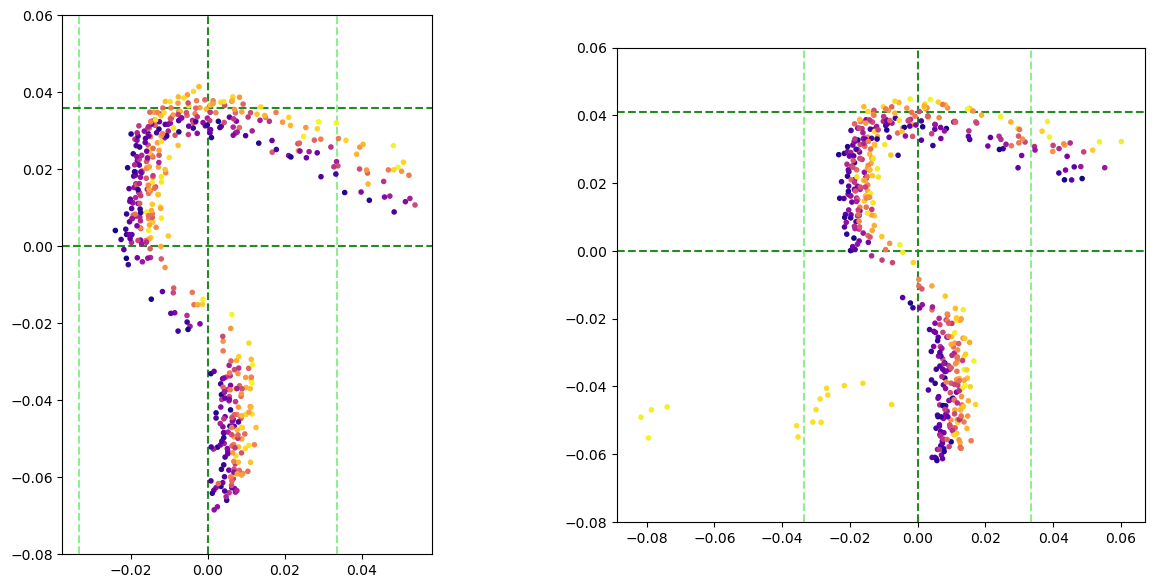

T_profil_ähnlich_54E4_schräg_random2.ply


In [199]:
preset = "PunkteSeiteVieleAusreisser"

templatefile = templatefiles[2]

cluster_this, cluster_other, cluster_pair = load_clusters(preset)
_, eigenvects = pca(cluster_this)
plottransform = get_transformmatrix(cluster_this, cluster_other, cluster_this.mean(axis=0), cluster_other.mean(axis=0), eigenvects)
plot_cluster_pair(cluster_this, cluster_other, plottransform, percentile=95, railhead_width = 0.067, centering="cluster");
print(templatefile)

In [97]:
threshold = 0.02 #05

In [200]:
_, eigenvects = pca(cluster_pair)

# center = cluster_pair.mean(axis=0) # Funktioniert nicht bei Lücke 
center = get_central_point(cluster_this.mean(axis=0), cluster_other.mean(axis=0))
centered = cluster_pair - center

centered_pcd = o3d.geometry.PointCloud()
centered_pcd.points = o3d.utility.Vector3dVector(centered)

translation = np.array([0, 0, centered[:,2].max()])
#translation = np.array([0, 0, np.percentile(centered[:,2], 70)])

#translation = None

print("Translation", translation)
trans_init = get_o3d_transform(eigenvects, translation)

target = centered_pcd
source = get_template(templatefile)

print("Evaluate initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

draw_registration_result(source, target, trans_init)

Translation [0.         0.         0.04309929]
Evaluate initial alignment
RegistrationResult with fitness=4.534900e-01, inlier_rmse=1.444042e-02, and correspondence_set size of 13202
Access transformation to get result.


### Point to Point ICP

In [195]:
start = time.time()
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
print("Time:", time.time() - start)

draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP
RegistrationResult with fitness=1.711322e-01, inlier_rmse=1.439724e-02, and correspondence_set size of 4982
Access transformation to get result.
Transformation is:
[[-9.32804156e-01 -3.58266972e-01 -2.99786016e-02  1.91660807e-02]
 [-3.60383640e-01  9.27266649e-01  6.70011015e-02  3.71219752e-03]
 [ 1.94894899e-04 -1.08725977e-01  9.97302429e-01  7.63165336e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Time: 0.17391633987426758


### Point to Plain ICP

In [152]:
start = time.time()
print("Apply point-to-plane ICP")

# Point-to-plane ICP requires normals for the target
nn_distance = np.mean(target.compute_nearest_neighbor_distance())  
print("nn distance", nn_distance)  
  
#setting the radius search to compute normals  
radius_normals=nn_distance*4  
target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)  

reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
print("Time:", time.time() - start)
draw_registration_result(source, target, reg_p2l.transformation)

Apply point-to-plane ICP
nn distance 0.007903435254969074
RegistrationResult with fitness=5.826807e-01, inlier_rmse=1.189281e-02, and correspondence_set size of 16963
Access transformation to get result.
Transformation is:
[[ 0.46774818  0.88382661 -0.00386614  0.08708706]
 [ 0.88381336 -0.46779732  0.00200272 -0.06125159]
 [ 0.00925159  0.0040239   0.99999052  0.05350566]
 [ 0.          0.          0.          1.        ]]
Time: 0.30367064476013184
